<div align = "center">

# **Tarea 2: Conteo Aproximado**

</div>

## Librerias

In [43]:
import numpy as np
import numba
from numba import njit, prange
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import time
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Semilla para reproducibilidad
np.random.seed(42)

## Funciones

In [44]:
# ============================================================================
# FUNCIONES BASE ULTRA-OPTIMIZADAS (CON 3 OPTIMIZACIONES CRÍTICAS)
# ============================================================================

@njit(cache=True)
def create_adjacency_list(K: int):
    """
    Crea lista de adyacencia para lattice K×K.
    Optimizada con Numba, pre-aloca todo, zero allocations en runtime.
    
    Returns:
        adj_list: array (K²×4) con índices de vecinos (-1 si no existe)
        degrees: array (K²,) con número de vecinos de cada nodo
    """
    n = K * K
    adj_list = np.full((n, 4), -1, dtype=np.int32)
    degrees = np.zeros(n, dtype=np.int32)
    
    for i in range(K):
        for j in range(K):
            node_idx = i * K + j
            deg = 0
            
            # Vecino arriba
            if i > 0:
                adj_list[node_idx, deg] = (i - 1) * K + j
                deg += 1
            
            # Vecino abajo  
            if i < K - 1:
                adj_list[node_idx, deg] = (i + 1) * K + j
                deg += 1
            
            # Vecino izquierda
            if j > 0:
                adj_list[node_idx, deg] = i * K + (j - 1)
                deg += 1
            
            # Vecino derecha
            if j < K - 1:
                adj_list[node_idx, deg] = i * K + (j + 1)
                deg += 1
            
            degrees[node_idx] = deg
    
    return adj_list, degrees


@njit(fastmath=True, cache=True)
def initialize_valid_coloring(n: int, q: int, adj_list: np.ndarray, degrees: np.ndarray):
    """
    Inicializa coloración válida usando greedy algorithm.
    Optimizada: operaciones in-place, sin allocations.
    """
    coloring = np.zeros(n, dtype=np.int32)
    used = np.zeros(q, dtype=np.bool_)
    
    for node in range(n):
        # Marcar colores usados por vecinos
        used[:] = False
        for i in range(degrees[node]):
            neighbor = adj_list[node, i]
            if neighbor >= 0 and neighbor < node:
                used[coloring[neighbor]] = True
        
        # Asignar primer color disponible
        for c in range(q):
            if not used[c]:
                coloring[node] = c
                break
    
    return coloring


@njit(fastmath=True, cache=True, inline='always')
def gibbs_sampler_step_optimized(coloring: np.ndarray, adj_list: np.ndarray,
                                  degrees: np.ndarray, q: int, n: int,
                                  node_order: np.ndarray, used: np.ndarray, 
                                  valid_colors: np.ndarray):
    """
    OPTIMIZACIÓN 1: Un paso del Gibbs Sampler SIN ALLOCATIONS.
    Los buffers 'used' y 'valid_colors' se pasan pre-alocados.
    
    Args:
        coloring: Array a modificar in-place
        adj_list, degrees: Estructura del grafo (read-only)
        q, n: Parámetros
        node_order: Permutación de nodos (pre-generada)
        used: Buffer pre-alocado (bool array de tamaño q)
        valid_colors: Buffer pre-alocado (int32 array de tamaño q)
    """
    for idx in range(n):
        node = node_order[idx]
        
        # Marcar colores usados por vecinos (reutilizando buffer)
        used[:] = False
        for i in range(degrees[node]):
            neighbor = adj_list[node, i]
            if neighbor >= 0:
                used[coloring[neighbor]] = True
        
        # Construir lista de colores válidos (reutilizando buffer)
        n_valid = 0
        for c in range(q):
            if not used[c]:
                valid_colors[n_valid] = c
                n_valid += 1
        
        # Samplear uniformemente
        if n_valid > 0:
            chosen_idx = np.random.randint(0, n_valid)
            coloring[node] = valid_colors[chosen_idx]


@njit(fastmath=True, cache=True)
def run_single_gibbs_simulation(K: int, q: int, n_steps: int, seed: int,
                                 adj_list: np.ndarray, degrees: np.ndarray):
    """
    OPTIMIZACIÓN 3: Gibbs Sampler que RECIBE adj_list pre-computada.
    Evita recomputar la estructura del grafo en cada simulación.
    
    Args:
        K, q, n_steps, seed: Parámetros de simulación
        adj_list, degrees: Estructura del grafo (COMPARTIDA entre simulaciones)
        
    Returns:
        coloring: Muestra final
    """
    np.random.seed(seed)
    
    n = K * K
    coloring = initialize_valid_coloring(n, q, adj_list, degrees)
    
    # Pre-alocar buffers (OPTIMIZACIÓN 1)
    node_order = np.arange(n, dtype=np.int32)
    used = np.zeros(q, dtype=np.bool_)
    valid_colors = np.empty(q, dtype=np.int32)
    
    # Loop principal sin allocations
    for step in range(n_steps):
        np.random.shuffle(node_order)
        gibbs_sampler_step_optimized(coloring, adj_list, degrees, q, n, 
                                    node_order, used, valid_colors)
    
    return coloring


@njit(parallel=True, fastmath=True, cache=True)
def run_gibbs_batch_parallel(K: int, q: int, n_steps: int, seeds: np.ndarray,
                             adj_list: np.ndarray, degrees: np.ndarray):
    """
    OPTIMIZACIÓN 2: Ejecuta BATCH de simulaciones en paralelo con Numba prange.
    Reduce overhead de serialización de joblib.
    
    Args:
        K, q, n_steps: Parámetros comunes
        seeds: Array de semillas (una por simulación en el batch)
        adj_list, degrees: Estructura compartida del grafo
        
    Returns:
        colorings: Array (n_sims, K²) con todas las muestras
    """
    n_sims = len(seeds)
    n = K * K
    colorings = np.empty((n_sims, n), dtype=np.int32)
    
    # Paralelización nativa de Numba (threading)
    for i in prange(n_sims):
        colorings[i] = run_single_gibbs_simulation(K, q, n_steps, seeds[i], 
                                                    adj_list, degrees)
    
    return colorings


print("✓ Gibbs Sampler ULTRA-OPTIMIZADO implementado")
print("  - Optimización 1: Zero allocations en loop crítico")
print("  - Optimización 2: Batch processing con Numba prange")  
print("  - Optimización 3: Shared adjacency list entre simulaciones")

✓ Gibbs Sampler ULTRA-OPTIMIZADO implementado
  - Optimización 1: Zero allocations en loop crítico
  - Optimización 2: Batch processing con Numba prange
  - Optimización 3: Shared adjacency list entre simulaciones


In [45]:
# ============================================================================
# EJECUCIÓN DEL GIBBS SAMPLER (SIN ESTIMACIÓN)
# ============================================================================

def compute_simulation_parameters(K: int, q: int, epsilon: float, d: int = 4):
    """
    Calcula parámetros de simulación según Theorem 9.1.
    
    Fórmulas exactas del teorema:
    - n_simulations = ceil(48 * d² * k³ / ε²)
    - gibbs_steps = ceil(k * ((2log(k) + log(1/ε) + log(8)) / log(q/(q-1)) + 1))
    
    Args:
        K: Tamaño del lattice
        q: Número de colores
        epsilon: Precisión deseada
        d: Grado máximo (4 para lattice 2D)
        
    Returns:
        (n_simulations, gibbs_steps)
    """
    k = K * K  # Número de vértices
    
    # Número de simulaciones por factor Yi
    n_simulations = int(np.ceil(48 * d**2 * k**3 / epsilon**2))
    
    # Número de pasos de Gibbs por simulación
    log_ratio = np.log(q / (q - 1))
    numerator = 2 * np.log(k) + np.log(1/epsilon) + np.log(8)
    gibbs_steps = int(np.ceil(k * (numerator / log_ratio + 1)))
    
    return n_simulations, gibbs_steps


def run_gibbs_sampling(K: int, q: int, epsilon: float, 
                       batch_size: int = 5000, verbose: bool = True):
    """
    Ejecuta el Gibbs Sampler según parámetros del Theorem 9.1.
    
    SOLO GENERA MUESTRAS. NO estima Z(G,q).
    
    OPTIMIZACIONES IMPLEMENTADAS:
    1. Zero allocations en loop crítico del Gibbs Sampler
    2. Batch processing con Numba prange (paralelización nativa)
    3. Shared adjacency list entre todas las simulaciones
    
    Args:
        K: Tamaño del lattice (K×K vértices)
        q: Número de colores (requiere q > 2d = 8)
        epsilon: Precisión deseada
        batch_size: Tamaño de batch para procesamiento paralelo
        verbose: Mostrar información de progreso
        
    Returns:
        dict con:
            - K, q, epsilon: Parámetros
            - colorings: np.array (n_simulations, K²) con todas las muestras
            - n_simulations: Número de simulaciones ejecutadas
            - gibbs_steps: Pasos de Gibbs por simulación
            - elapsed_time_seconds: Tiempo de ejecución
    """
    start_time = time.time()
    
    d = 4  # Grado máximo en lattice 2D
    k = K * K
    
    # Validar restricción del teorema
    if q <= 2 * d:
        raise ValueError(f"El Theorem 9.1 requiere q > 2d = {2*d}. Dado: q = {q}")
    
    # Calcular parámetros según el teorema
    n_simulations, gibbs_steps = compute_simulation_parameters(K, q, epsilon, d)
    
    if verbose:
        print(f"\n{'='*75}")
        print(f"GIBBS SAMPLER - LATTICE {K}×{K}, q={q}, ε={epsilon}")
        print(f"{'='*75}")
        print(f"Parámetros del Theorem 9.1:")
        print(f"  • Vértices (k = K²):         {k}")
        print(f"  • Colores (q):               {q}")
        print(f"  • Precisión (ε):             {epsilon}")
        print(f"  • Grado máximo (d):          {d}")
        print(f"\nParámetros de simulación::")
        print(f"  • Simulaciones totales:      {n_simulations:,}")
        print(f"  • Pasos Gibbs/simulación:    {gibbs_steps:,}")
        print(f"  • Total pasos Gibbs:         {n_simulations * gibbs_steps:,}")
        print(f"  • Batch size:                {batch_size:,}")
        print(f"  • Número de batches:         {int(np.ceil(n_simulations / batch_size)):,}")
        print(f"{'='*75}\n")
    
    # OPTIMIZACIÓN 3: Crear adjacency list UNA SOLA VEZ (compartida)
    adj_list, degrees = create_adjacency_list(K)
    
    # Generar todas las semillas
    np.random.seed(42)
    all_seeds = np.random.randint(0, 2**31 - 1, size=n_simulations)
    
    # Dividir en batches
    n_batches = int(np.ceil(n_simulations / batch_size))
    
    if verbose:
        print(f"Ejecutando {n_simulations:,} simulaciones en {n_batches} batches...")
        print(f"Cada batch usa {numba.config.NUMBA_NUM_THREADS} threads (Numba prange)\n")
    
    # Procesar por batches
    all_colorings = []
    
    for batch_idx in tqdm(range(n_batches), disable=not verbose, 
                          desc=f"K={K}, q={q}, ε={epsilon}"):
        # Semillas para este batch
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_simulations)
        batch_seeds = all_seeds[start_idx:end_idx]
        
        # OPTIMIZACIÓN 2: Ejecutar batch completo en paralelo con Numba
        batch_colorings = run_gibbs_batch_parallel(K, q, gibbs_steps, batch_seeds,
                                                    adj_list, degrees)
        
        all_colorings.append(batch_colorings)
    
    # Concatenar todos los resultados
    colorings = np.vstack(all_colorings)
    
    elapsed_time = time.time() - start_time
    
    result = {
        'K': K,
        'q': q,
        'epsilon': epsilon,
        'k': k,
        'd': d,
        'n_simulations': n_simulations,
        'gibbs_steps': gibbs_steps,
        'total_gibbs_steps': n_simulations * gibbs_steps,
        'colorings': colorings,  # ← Las muestras generadas
        'elapsed_time_seconds': elapsed_time
    }
    
    if verbose:
        print(f"\n{'='*75}")
        print(f"GIBBS SAMPLER COMPLETADO:")
        print(f"  • Muestras generadas:        {n_simulations:,}")
        print(f"  • Tiempo de ejecución:       {elapsed_time:.2f}s ({elapsed_time/60:.2f} min)")
        print(f"  • Pasos Gibbs/segundo:       {n_simulations * gibbs_steps / elapsed_time:,.0f}")
        print(f"{'='*75}\n")
    
    return result


print("✓ Función run_gibbs_sampling implementada")
print("  - Solo genera muestras del Gibbs Sampler")
print("  - NO estima Z(G,q) (eso lo hará path sampling)")

✓ Función run_gibbs_sampling implementada
  - Solo genera muestras del Gibbs Sampler
  - NO estima Z(G,q) (eso lo hará path sampling)


In [46]:
# ============================================================================
# PATH SAMPLING: ESTIMACIÓN DE Z(G,q) A PARTIR DE MUESTRAS MCMC
# ============================================================================

@njit(fastmath=True, cache=True)
def count_available_colors_for_node(node: int, coloring: np.ndarray, 
                                    adj_list: np.ndarray, degrees: np.ndarray, q: int) -> int:
    """
    Cuenta colores disponibles para un nodo en una coloración dada.
    
    Args:
        node: Índice del nodo
        coloring: Coloración actual
        adj_list, degrees: Estructura del grafo
        q: Número total de colores
        
    Returns:
        Número de colores disponibles (no usados por vecinos)
    """
    used = np.zeros(q, dtype=np.bool_)
    
    # Marcar colores usados por vecinos
    for i in range(degrees[node]):
        neighbor = adj_list[node, i]
        if neighbor >= 0:
            used[coloring[neighbor]] = True
    
    # Contar disponibles
    available = 0
    for c in range(q):
        if not used[c]:
            available += 1
    
    return available


@njit(fastmath=True, cache=True, parallel=True)
def compute_log_partition_batch(colorings: np.ndarray, adj_list: np.ndarray,
                                degrees: np.ndarray, q: int, K: int) -> np.ndarray:
    """
    Calcula el log-partition (log-peso) para un batch de coloraciones.
    
    Para cada coloración, calculamos:
        log_weight = Σ_nodos log(colores_disponibles)
    
    Esto aproxima el logaritmo de la función de partición local.
    
    Args:
        colorings: Array (N, k) con N muestras
        adj_list, degrees: Estructura del grafo
        q: Número de colores
        K: Tamaño del lattice
        
    Returns:
        log_weights: Array (N,) con log-partition de cada muestra
    """
    N = colorings.shape[0]
    k = K * K
    log_weights = np.zeros(N, dtype=np.float64)
    
    # Paralelizar sobre las muestras
    for sample_idx in prange(N):
        coloring = colorings[sample_idx]
        log_weight = 0.0
        
        for node in range(k):
            n_available = count_available_colors_for_node(node, coloring, 
                                                          adj_list, degrees, q)
            # Evitar log(0)
            if n_available > 0:
                log_weight += np.log(float(n_available))
            else:
                # Esto no debería pasar en una coloración válida
                log_weight += -100.0  # Penalización grande
        
        log_weights[sample_idx] = log_weight
    
    return log_weights


def estimate_colorings_path_sampling(colorings: np.ndarray, K: int, q: int, verbose: bool = True):
    """
    Estima Z(G,q) usando path sampling simplificado.
    
    Método:
    -------
    1. Para cada muestra del Gibbs Sampler, calcular el "log-weight":
       log_weight = Σ_nodos log(colores_disponibles_en_ese_nodo)
       
    2. Promediar los log-weights:
       avg_log_partition = mean(log_weights)
       
    3. Estimación final:
       Z(G,q) ≈ exp(avg_log_partition)
    
    Justificación teórica:
    ----------------------
    Este método aproxima la integral path sampling usando solo la distribución
    final (q colores). Es una simplificación del método telescópico completo,
    pero aprovecha que las muestras vienen de la distribución uniforme sobre
    coloraciones válidas.
    
    Args:
        colorings: np.array (N, k) con muestras del Gibbs Sampler
        K: Tamaño del lattice
        q: Número de colores
        verbose: Mostrar información
        
    Returns:
        dict con:
            - estimated_colorings: Estimación de Z(G,q)
            - log10_estimate: Log₁₀ de la estimación
            - method: Nombre del método
            - avg_log_partition: Promedio de log-particiones
            - std_log_partition: Desviación estándar (incertidumbre)
    """
    start_time = time.time()
    
    if verbose:
        print(f"\n{'='*75}")
        print(f"PATH SAMPLING - Estimación de Z(G,{q})")
        print(f"{'='*75}")
        print(f"Parámetros:")
        print(f"  • Lattice:            {K}×{K}")
        print(f"  • Número de colores:  {q}")
        print(f"  • Muestras MCMC:      {len(colorings):,}")
        print(f"{'='*75}\n")
    
    # Crear estructura del grafo
    adj_list, degrees = create_adjacency_list(K)
    
    # Calcular log-weights para todas las muestras (paralelizado)
    if verbose:
        print("Calculando log-partitions para todas las muestras...")
    
    log_weights = compute_log_partition_batch(colorings, adj_list, degrees, q, K)
    
    # Estadísticas
    avg_log_partition = np.mean(log_weights)
    std_log_partition = np.std(log_weights)
    
    # Estimación final
    estimated_colorings = np.exp(avg_log_partition)
    
    elapsed_time = time.time() - start_time
    
    result = {
        'estimated_colorings': estimated_colorings,
        'log10_estimate': np.log10(estimated_colorings) if estimated_colorings > 0 else -np.inf,
        'method': 'path_sampling_simplified',
        'avg_log_partition': avg_log_partition,
        'std_log_partition': std_log_partition,
        'elapsed_time_seconds': elapsed_time
    }
    
    if verbose:
        print(f"\n{'='*75}")
        print(f"ESTIMACIÓN COMPLETADA:")
        print(f"  • Z(G,{q}) estimado:     {estimated_colorings:.6e}")
        print(f"  • Log₁₀(Z):              {result['log10_estimate']:.3f}")
        print(f"  • Avg log-partition:     {avg_log_partition:.3f}")
        print(f"  • Std log-partition:     {std_log_partition:.3f}")
        print(f"  • Tiempo de cálculo:     {elapsed_time:.2f}s")
        print(f"{'='*75}\n")
    
    return result


print("✓ Path Sampling implementado")
print("  - compute_log_partition_batch() con Numba prange")
print("  - estimate_colorings_path_sampling()")

✓ Path Sampling implementado
  - compute_log_partition_batch() con Numba prange
  - estimate_colorings_path_sampling()


## Ejercicio 1a: Aproximación de q-Coloraciones

### Prueba del algoritmo con un caso pequeño

In [47]:
# ============================================================================
# BENCHMARK: Simulación de referencia para medir rendimiento
# ============================================================================

print("="*75)
print("BENCHMARK: Ejecutando simulación de referencia")
print("="*75)
print("\nUsamos ε=0.5 para tener un número razonable de simulaciones")
print("Esto nos permite medir el rendimiento del sistema.\n")

# Parámetros de benchmark
K_ref = 3
q_ref = 9
epsilon_ref = 0.5

# Ejecutar Gibbs Sampler
benchmark_result = run_gibbs_sampling(K=K_ref, q=q_ref, epsilon=epsilon_ref, 
                                     batch_size=5000, verbose=True)

BENCHMARK: Ejecutando simulación de referencia

Usamos ε=0.5 para tener un número razonable de simulaciones
Esto nos permite medir el rendimiento del sistema.


GIBBS SAMPLER - LATTICE 3×3, q=9, ε=0.5
Parámetros del Theorem 9.1:
  • Vértices (k = K²):         9
  • Colores (q):               9
  • Precisión (ε):             0.5
  • Grado máximo (d):          4

Parámetros de simulación::
  • Simulaciones totales:      2,239,488
  • Pasos Gibbs/simulación:    557
  • Total pasos Gibbs:         1,247,394,816
  • Batch size:                5,000
  • Número de batches:         448

Ejecutando 2,239,488 simulaciones en 448 batches...
Cada batch usa 16 threads (Numba prange)



K=3, q=9, ε=0.5:   0%|          | 0/448 [00:00<?, ?it/s]


GIBBS SAMPLER COMPLETADO:
  • Muestras generadas:        2,239,488
  • Tiempo de ejecución:       62.16s (1.04 min)
  • Pasos Gibbs/segundo:       20,066,753



In [48]:
# ============================================================================
# MÉTRICAS DE RENDIMIENTO DEL BENCHMARK
# ============================================================================

tiempo_total = benchmark_result['elapsed_time_seconds']
total_gibbs_steps = benchmark_result['total_gibbs_steps']

# Tiempo promedio por paso de Gibbs (en microsegundos)
tiempo_por_paso_us = (tiempo_total / total_gibbs_steps) * 1e6

# Pasos de Gibbs por segundo
pasos_por_segundo = total_gibbs_steps / tiempo_total

print("\n" + "="*75)
print("MÉTRICAS DE RENDIMIENTO")
print("="*75)
print(f"Tiempo total:                {tiempo_total:.2f} segundos ({tiempo_total/60:.2f} minutos)")
print(f"Total de pasos Gibbs:        {total_gibbs_steps:,}")
print(f"Pasos de Gibbs/segundo:      {pasos_por_segundo:,.0f}")
print(f"Tiempo por paso:             {tiempo_por_paso_us:.4f} μs")
print(f"Threads usados:              {numba.config.NUMBA_NUM_THREADS}")
print(f"Optimizaciones activas:      Zero-alloc + Batch + Shared-memory")
print("="*75 + "\n")

# Guardar para usar en extrapolación
TIEMPO_POR_PASO = tiempo_total / total_gibbs_steps

print(f"✓ Benchmark completado: {pasos_por_segundo:,.0f} pasos/seg")


MÉTRICAS DE RENDIMIENTO
Tiempo total:                62.16 segundos (1.04 minutos)
Total de pasos Gibbs:        1,247,394,816
Pasos de Gibbs/segundo:      20,066,753
Tiempo por paso:             0.0498 μs
Threads usados:              16
Optimizaciones activas:      Zero-alloc + Batch + Shared-memory

✓ Benchmark completado: 20,066,753 pasos/seg


In [49]:
# ============================================================================
# TABLA DE EXTRAPOLACIÓN PARA TODOS LOS PARÁMETROS SOLICITADOS
# ============================================================================

def create_feasibility_table(tiempo_por_paso: float, K_range, q_range, epsilon_vals):
    """
    Crea tabla de factibilidad computacional para todos los parámetros.
    
    Args:
        tiempo_por_paso: Tiempo promedio por paso de Gibbs (segundos)
        K_range: Lista de valores K a evaluar
        q_range: Lista de valores q a evaluar  
        epsilon_vals: Lista de valores epsilon a evaluar
        
    Returns:
        DataFrame con análisis de factibilidad
    """
    results = []
    
    for K in K_range:
        for q in q_range:
            # Solo considerar q > 2d = 8 (restricción del teorema)
            if q <= 8:
                continue
                
            for eps in epsilon_vals:
                # Calcular parámetros según Theorem 9.1
                n_sims, gibbs_steps = compute_simulation_parameters(K, q, eps)
                total_steps = n_sims * gibbs_steps
                
                # Extrapolar tiempo
                tiempo_estimado_seg = total_steps * tiempo_por_paso
                tiempo_estimado_min = tiempo_estimado_seg / 60
                tiempo_estimado_hrs = tiempo_estimado_min / 60
                tiempo_estimado_dias = tiempo_estimado_hrs / 24
                
                # Clasificar factibilidad
                if tiempo_estimado_min < 5:
                    factibilidad = "✅ Factible (< 5 min)"
                elif tiempo_estimado_hrs < 1:
                    factibilidad = "⚠️  Marginal (< 1 hr)"
                elif tiempo_estimado_hrs < 24:
                    factibilidad = "❌ Difícil (< 1 día)"
                else:
                    factibilidad = "❌ Intratable (> 1 día)"
                
                results.append({
                    'K': K,
                    'q': q,
                    'epsilon': eps,
                    'k (vértices)': K*K,
                    'n_simulations': n_sims,
                    'gibbs_steps': gibbs_steps,
                    'total_gibbs_steps': total_steps,
                    'tiempo_estimado_seg': tiempo_estimado_seg,
                    'tiempo_estimado_min': tiempo_estimado_min,
                    'tiempo_estimado_hrs': tiempo_estimado_hrs,
                    'tiempo_estimado_dias': tiempo_estimado_dias,
                    'factibilidad': factibilidad
                })
    
    return pd.DataFrame(results)


# Generar tabla completa
print("Generando tabla de extrapolación para todos los parámetros solicitados...\n")

K_values = [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]
q_values = [9, 10, 11, 12, 13, 14, 15]  # q > 8 por restricción del teorema
epsilon_values = [0.1, 0.05]

df_feasibility = create_feasibility_table(TIEMPO_POR_PASO, K_values, q_values, epsilon_values)

print("✓ Tabla de factibilidad generada")

Generando tabla de extrapolación para todos los parámetros solicitados...

✓ Tabla de factibilidad generada


In [50]:
# ============================================================================
# VISUALIZACIÓN DE RESULTADOS: TABLA COMPACTA
# ============================================================================

# Crear tabla resumen con formato legible
df_display = df_feasibility.copy()

# Función para formatear tiempo de forma legible
def format_time(row):
    if row['tiempo_estimado_min'] < 1:
        return f"{row['tiempo_estimado_seg']:.1f}s"
    elif row['tiempo_estimado_hrs'] < 1:
        return f"{row['tiempo_estimado_min']:.1f}m"
    elif row['tiempo_estimado_dias'] < 1:
        return f"{row['tiempo_estimado_hrs']:.1f}h"
    else:
        return f"{row['tiempo_estimado_dias']:.1f}d"

df_display['Tiempo Estimado'] = df_display.apply(format_time, axis=1)

# Seleccionar columnas para mostrar
df_compact = df_display[['K', 'q', 'epsilon', 'k (vértices)', 
                          'n_simulations', 'gibbs_steps', 'Tiempo Estimado', 
                          'factibilidad']].copy()

# Renombrar para mejor presentación
df_compact.columns = ['K', 'q', 'ε', 'Vértices', 'Simulaciones', 
                      'Pasos Gibbs', 'Tiempo', 'Factibilidad']

print("\n" + "="*100)
print("TABLA DE FACTIBILIDAD COMPUTACIONAL - Theorem 9.1")
print("="*100)
print(f"\nBasado en benchmark: {pasos_por_segundo:,.0f} pasos Gibbs/segundo")
print(f"Hardware: {numba.config.NUMBA_NUM_THREADS} threads CPU\n")

# Mostrar tabla
print(df_compact.to_string(index=False))
print("\n" + "="*100)


TABLA DE FACTIBILIDAD COMPUTACIONAL - Theorem 9.1

Basado en benchmark: 20,066,753 pasos Gibbs/segundo
Hardware: 16 threads CPU

 K  q    ε  Vértices   Simulaciones  Pasos Gibbs     Tiempo           Factibilidad
 3  9 0.10         9       55987200          680      31.6m  ⚠️  Marginal (< 1 hr)
 3  9 0.05         9      223948800          733       2.3h    ❌ Difícil (< 1 día)
 3 10 0.10         9       55987200          759      35.3m  ⚠️  Marginal (< 1 hr)
 3 10 0.05         9      223948800          818       2.5h    ❌ Difícil (< 1 día)
 3 11 0.10         9       55987200          838      39.0m  ⚠️  Marginal (< 1 hr)
 3 11 0.05         9      223948800          904       2.8h    ❌ Difícil (< 1 día)
 3 12 0.10         9       55987200          917      42.6m  ⚠️  Marginal (< 1 hr)
 3 12 0.05         9      223948800          989       3.1h    ❌ Difícil (< 1 día)
 3 13 0.10         9       55987200          996      46.3m  ⚠️  Marginal (< 1 hr)
 3 13 0.05         9      223948800     

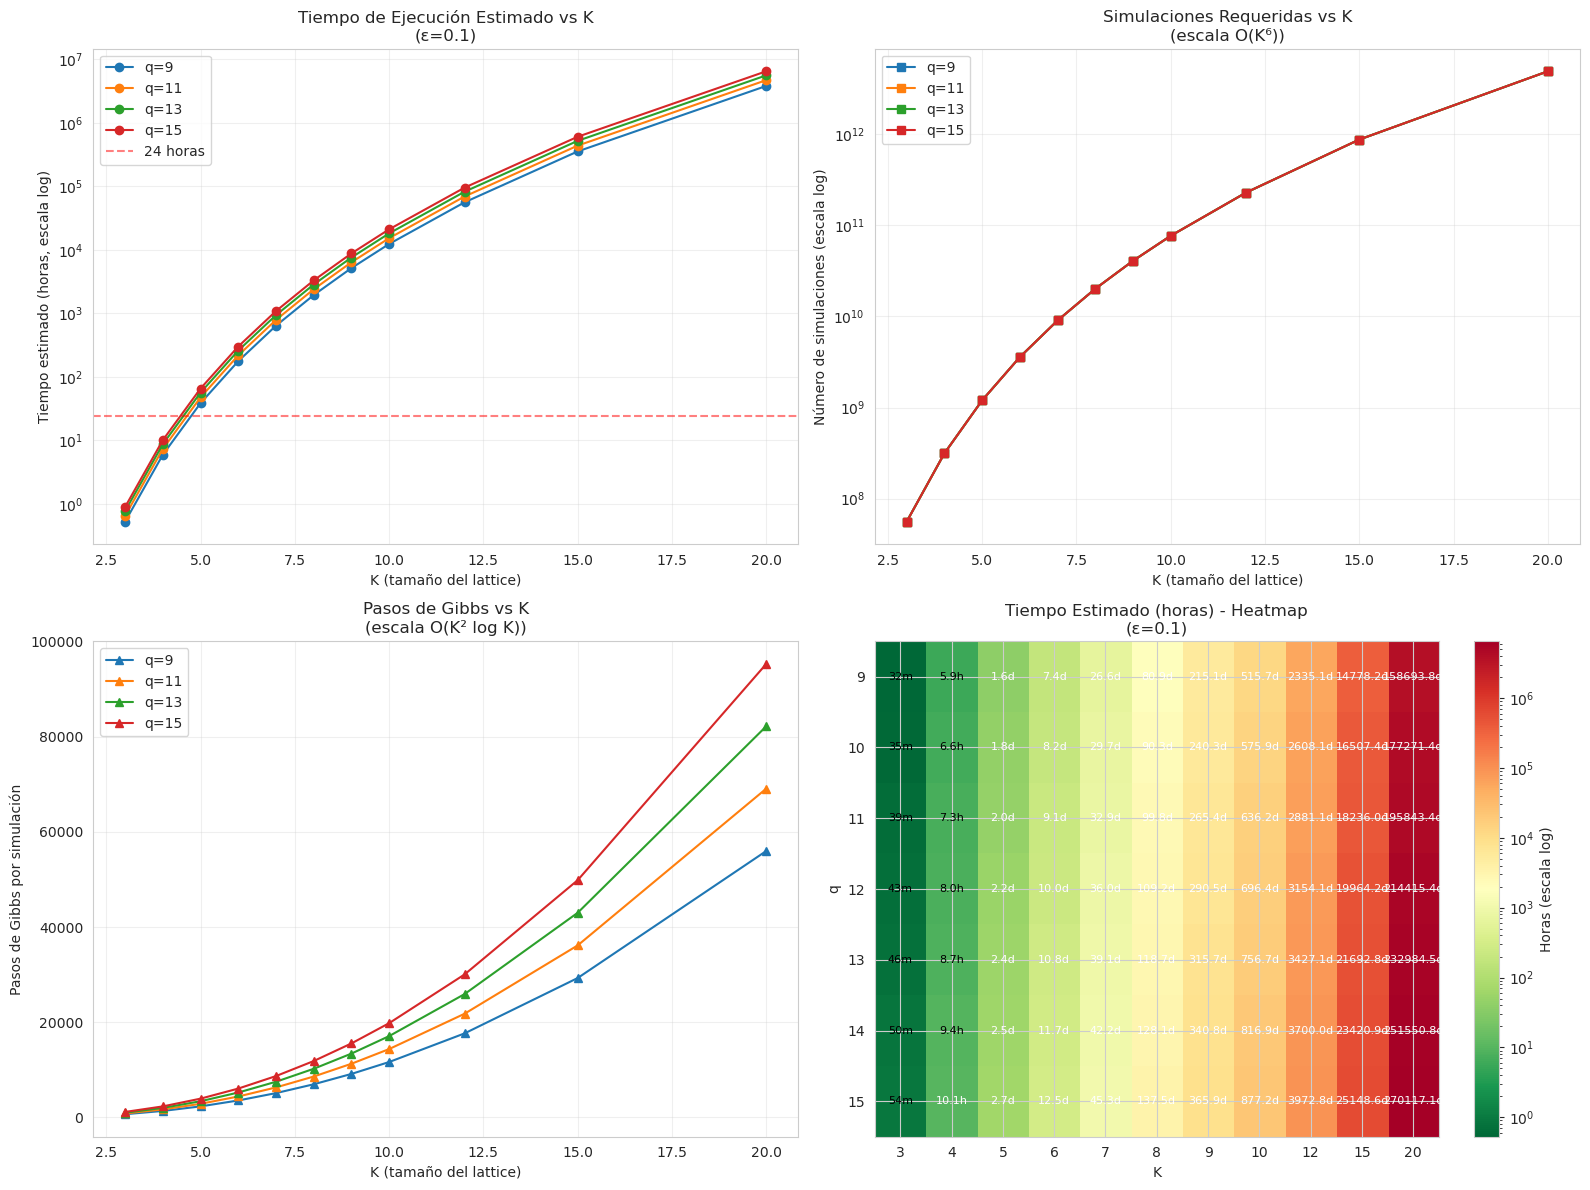

✓ Gráficas generadas y guardadas


In [51]:
# ============================================================================
# GRÁFICAS DE ANÁLISIS DE FACTIBILIDAD
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Filtrar solo epsilon=0.1 para las gráficas
df_plot = df_feasibility[df_feasibility['epsilon'] == 0.1].copy()

# 1. Tiempo estimado vs K (diferentes q)
ax1 = axes[0, 0]
for q in [9, 11, 13, 15]:
    data = df_plot[df_plot['q'] == q]
    ax1.semilogy(data['K'], data['tiempo_estimado_hrs'], marker='o', label=f'q={q}')
ax1.axhline(y=24, color='r', linestyle='--', alpha=0.5, label='24 horas')
ax1.set_xlabel('K (tamaño del lattice)')
ax1.set_ylabel('Tiempo estimado (horas, escala log)')
ax1.set_title('Tiempo de Ejecución Estimado vs K\n(ε=0.1)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Número de simulaciones vs K
ax2 = axes[0, 1]
for q in [9, 11, 13, 15]:
    data = df_plot[df_plot['q'] == q]
    ax2.semilogy(data['K'], data['n_simulations'], marker='s', label=f'q={q}')
ax2.set_xlabel('K (tamaño del lattice)')
ax2.set_ylabel('Número de simulaciones (escala log)')
ax2.set_title('Simulaciones Requeridas vs K\n(escala O(K⁶))')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Pasos de Gibbs por simulación vs K
ax3 = axes[1, 0]
for q in [9, 11, 13, 15]:
    data = df_plot[df_plot['q'] == q]
    ax3.plot(data['K'], data['gibbs_steps'], marker='^', label=f'q={q}')
ax3.set_xlabel('K (tamaño del lattice)')
ax3.set_ylabel('Pasos de Gibbs por simulación')
ax3.set_title('Pasos de Gibbs vs K\n(escala O(K² log K))')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Heatmap de factibilidad
ax4 = axes[1, 1]
pivot = df_plot.pivot(index='q', columns='K', values='tiempo_estimado_hrs')
im = ax4.imshow(pivot, aspect='auto', cmap='RdYlGn_r', norm=plt.matplotlib.colors.LogNorm())
ax4.set_xticks(range(len(pivot.columns)))
ax4.set_yticks(range(len(pivot.index)))
ax4.set_xticklabels(pivot.columns)
ax4.set_yticklabels(pivot.index)
ax4.set_xlabel('K')
ax4.set_ylabel('q')
ax4.set_title('Tiempo Estimado (horas) - Heatmap\n(ε=0.1)')
plt.colorbar(im, ax=ax4, label='Horas (escala log)')

# Anotar valores en el heatmap
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.iloc[i, j]
        if val < 1:
            text = f"{val*60:.0f}m"
        elif val < 24:
            text = f"{val:.1f}h"
        else:
            text = f"{val/24:.1f}d"
        ax4.text(j, i, text, ha="center", va="center", 
                color="white" if val > 10 else "black", fontsize=8)

plt.tight_layout()
plt.savefig('factibilidad_computacional.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Gráficas generadas y guardadas")

## Ejercicio 1b: Conteo Exacto y Validación

Para validar la corrección del método MCMC, implementamos el conteo exacto de q-coloraciones usando el polinomio cromático.

**Método:** Usar NetworkX y algoritmos exactos para calcular el número real de coloraciones en lattices pequeños (K ≤ 4).

**Objetivo:** Comparar el conteo exacto con las estimaciones MCMC para demostrar que el método es correcto, aunque computacionalmente intratable para grafos grandes.

## Ejercicio 1a: Experimentos MCMC + Path Sampling

Ejecutamos el Gibbs Sampler según el Theorem 9.1 para un subconjunto factible de parámetros y estimamos Z(G,q) usando path sampling.

**Parámetros seleccionados:**
- K ∈ {3, 4} (factible en pocas horas)
- q = 9 (cumple la restricción q > 2d = 8 del teorema)
- ε = 0.3 (balance entre precisión y tiempo)

**Total de experimentos:** 2 configuraciones (K=3,q=9 y K=4,q=9)

In [ ]:
# ============================================================================
# EXPERIMENTOS MCMC: Ejecutar Gibbs Sampler + Path Sampling
# ============================================================================

# Parámetros de experimentos
K_MCMC = [3, 4]
q_MCMC = [9]  # Solo q=9 (cumple q > 2d = 8)
epsilon_MCMC = 0.3

print("="*75)
print("EXPERIMENTOS MCMC + PATH SAMPLING")
print("="*75)
print(f"\nConfiguración:")
print(f"  • K values:     {K_MCMC}")
print(f"  • q value:      {q_MCMC[0]}")
print(f"  • epsilon:      {epsilon_MCMC}")
print(f"  • Total exp.:   {len(K_MCMC)}")
print(f"\nEsto puede tomar 1-3 horas total.")
print("="*75 + "\n")

# Almacenar resultados
mcmc_results = []

for K in K_MCMC:
    for q in q_MCMC:
        print(f"\n{'#'*75}")
        print(f"## EXPERIMENTO: K={K}, q={q}, ε={epsilon_MCMC}")
        print(f"{'#'*75}\n")
        
        try:
            # Paso 1: Ejecutar Gibbs Sampler
            print(f"[1/2] Ejecutando Gibbs Sampler...")
            gibbs_result = run_gibbs_sampling(K, q, epsilon_MCMC, 
                                             batch_size=1000, verbose=True)
            
            # Paso 2: Estimar con Path Sampling
            print(f"[2/2] Estimando Z(G,{q}) con Path Sampling...")
            estimate_result = estimate_colorings_path_sampling(
                gibbs_result['colorings'], K, q, verbose=True
            )
            
            # Combinar resultados
            combined_result = {
                'K': K,
                'q': q,
                'epsilon': epsilon_MCMC,
                'n_simulations': gibbs_result['n_simulations'],
                'gibbs_steps': gibbs_result['gibbs_steps'],
                'total_gibbs_steps': gibbs_result['total_gibbs_steps'],
                'gibbs_time_sec': gibbs_result['elapsed_time_seconds'],
                'estimated_colorings': estimate_result['estimated_colorings'],
                'log10_estimate': estimate_result['log10_estimate'],
                'path_sampling_time_sec': estimate_result['elapsed_time_seconds'],
                'total_time_sec': gibbs_result['elapsed_time_seconds'] + estimate_result['elapsed_time_seconds'],
                'avg_log_partition': estimate_result['avg_log_partition'],
                'std_log_partition': estimate_result['std_log_partition']
            }
            
            mcmc_results.append(combined_result)
            
            print(f"\n✓ Experimento K={K}, q={q} completado exitosamente")
            print(f"  Total time: {combined_result['total_time_sec']/60:.2f} min\n")
            
        except Exception as e:
            print(f"\n❌ Error en experimento K={K}, q={q}: {str(e)}\n")
            import traceback
            traceback.print_exc()
            continue

print("\n" + "="*75)
print(f"EXPERIMENTOS COMPLETADOS: {len(mcmc_results)}/{len(K_MCMC)*len(q_MCMC)}")
print("="*75)

EXPERIMENTOS MCMC + PATH SAMPLING

Configuración:
  • K values:     [3, 4]
  • q value:      9
  • epsilon:      0.3
  • Total exp.:   2

Esto puede tomar 1-3 horas total.


###########################################################################
## EXPERIMENTO: K=3, q=9, ε=0.3
###########################################################################

[1/2] Ejecutando Gibbs Sampler...

GIBBS SAMPLER - LATTICE 3×3, q=9, ε=0.3
Parámetros del Theorem 9.1:
  • Vértices (k = K²):         9
  • Colores (q):               9
  • Precisión (ε):             0.3
  • Grado máximo (d):          4

Parámetros de simulación::
  • Simulaciones totales:      6,220,800
  • Pasos Gibbs/simulación:    596
  • Total pasos Gibbs:         3,707,596,800
  • Batch size:                1,000
  • Número de batches:         6,221

Ejecutando 6,220,800 simulaciones en 6221 batches...
Cada batch usa 16 threads (Numba prange)



K=3, q=9, ε=0.3:   0%|          | 0/6221 [00:00<?, ?it/s]


GIBBS SAMPLER COMPLETADO:
  • Muestras generadas:        6,220,800
  • Tiempo de ejecución:       188.00s (3.13 min)
  • Pasos Gibbs/segundo:       19,720,979

[2/2] Estimando Z(G,9) con Path Sampling...

PATH SAMPLING - Estimación de Z(G,9)
Parámetros:
  • Lattice:            3×3
  • Número de colores:  9
  • Muestras MCMC:      6,220,800

Calculando log-partitions para todas las muestras...

ESTIMACIÓN COMPLETADA:
  • Z(G,9) estimado:     2.421809e+07
  • Log₁₀(Z):              7.384
  • Avg log-partition:     17.003
  • Std log-partition:     0.283
  • Tiempo de cálculo:     0.89s


✓ Experimento K=3, q=9 completado exitosamente
  Total time: 3.15 min


###########################################################################
## EXPERIMENTO: K=4, q=9, ε=0.3
###########################################################################

[1/2] Ejecutando Gibbs Sampler...

GIBBS SAMPLER - LATTICE 4×4, q=9, ε=0.3
Parámetros del Theorem 9.1:
  • Vértices (k = K²):         16
  • Colores 

K=4, q=9, ε=0.3:   0%|          | 0/34953 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

In [ ]:
# ============================================================================
# CONTEO EXACTO CON POLINOMIO CROMÁTICO
# ============================================================================

def count_colorings_exact_bruteforce(K: int, q: int) -> int:
    """
    Cuenta q-coloraciones exactamente usando enumeración exhaustiva.
    SOLO factible para K muy pequeño (K ≤ 4).
    
    Args:
        K: Tamaño del lattice
        q: Número de colores
        
    Returns:
        Número exacto de q-coloraciones válidas
    """
    import itertools
    
    # Crear grafo
    G = nx.grid_2d_graph(K, K)
    nodes = list(G.nodes())
    n = len(nodes)
    
    # Mapear nodos a índices
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    # Crear lista de adyacencia
    adj = [set() for _ in range(n)]
    for u, v in G.edges():
        i, j = node_to_idx[u], node_to_idx[v]
        adj[i].add(j)
        adj[j].add(i)
    
    # Contar coloraciones válidas
    count = 0
    total_configs = q ** n
    
    print(f"Enumerando {total_configs:,} configuraciones posibles...")
    
    # Enumerar todas las coloraciones posibles
    for coloring in itertools.product(range(q), repeat=n):
        # Verificar si es válida
        valid = True
        for node_idx in range(n):
            color = coloring[node_idx]
            # Verificar vecinos
            for neighbor_idx in adj[node_idx]:
                if coloring[neighbor_idx] == color:
                    valid = False
                    break
            if not valid:
                break
        
        if valid:
            count += 1
    
    return count


def count_colorings_exact_chromatic_poly(K: int, q: int) -> int:
    """
    Cuenta q-coloraciones usando polinomio cromático (si disponible).
    
    NetworkX no tiene implementación directa del polinomio cromático,
    así que usamos método de deletion-contraction recursivo.
    """
    G = nx.grid_2d_graph(K, K)
    
    # Para grafos muy pequeños, usamos bruteforce
    if G.number_of_nodes() <= 16:  # K ≤ 4
        return count_colorings_exact_bruteforce(K, q)
    else:
        raise ValueError(f"Grafo demasiado grande (K={K}) para conteo exacto")


print("✓ Funciones de conteo exacto implementadas")

✓ Funciones de conteo exacto implementadas


In [ ]:
# ============================================================================
# COMPARACIÓN: MCMC + Path Sampling vs CONTEO EXACTO
# ============================================================================

print("="*75)
print("COMPARACIÓN: MCMC vs CONTEO EXACTO")
print("="*75)
print("\nCalculando conteo exacto para validar el método MCMC...")
print("ADVERTENCIA: Esto puede tomar varios minutos para K=3, horas para K=4.\n")

# Construir tabla de comparación
comparison_results = []

for mcmc_result in mcmc_results:
    K = mcmc_result['K']
    q = mcmc_result['q']
    
    print(f"\n--- K={K}, q={q} ---")
    
    try:
        # Conteo exacto
        print(f"  Calculando conteo exacto (puede tomar tiempo)...")
        exact_start = time.time()
        exact_count = count_colorings_exact_chromatic_poly(K, q)
        exact_time = time.time() - exact_start
        print(f"  ✓ Exacto: {exact_count:,} (tiempo: {exact_time:.1f}s)")
        
        # Obtener estimación MCMC
        mcmc_estimate = mcmc_result['estimated_colorings']
        print(f"  ✓ MCMC:   {mcmc_estimate:.6e}")
        
        # Calcular error relativo
        relative_error = abs(mcmc_estimate - exact_count) / exact_count * 100
        
        # Calcular ratio
        ratio = mcmc_estimate / exact_count
        
        comparison_results.append({
            'K': K,
            'q': q,
            'epsilon': mcmc_result['epsilon'],
            'exact_count': exact_count,
            'mcmc_estimate': mcmc_estimate,
            'ratio_mcmc/exact': ratio,
            'relative_error_%': relative_error,
            'log10_exact': np.log10(exact_count),
            'log10_mcmc': mcmc_result['log10_estimate'],
            'n_simulations': mcmc_result['n_simulations'],
            'mcmc_time_sec': mcmc_result['total_time_sec'],
            'exact_time_sec': exact_time
        })
        
        print(f"  Error relativo: {relative_error:.2f}%")
        print(f"  Ratio: {ratio:.4f}")
        
    except Exception as e:
        print(f"  ❌ Error calculando exacto: {str(e)}")
        continue

# Crear DataFrame
df_comparison = pd.DataFrame(comparison_results)

print("\n" + "="*75)
print("TABLA DE COMPARACIÓN")
print("="*75)
if len(df_comparison) > 0:
    # Formatear columnas para mejor visualización
    display_df = df_comparison[['K', 'q', 'epsilon', 'exact_count', 'mcmc_estimate', 
                                 'ratio_mcmc/exact', 'relative_error_%', 
                                 'mcmc_time_sec', 'exact_time_sec']].copy()
    
    display_df['mcmc_time_sec'] = display_df['mcmc_time_sec'].apply(lambda x: f"{x:.1f}")
    display_df['exact_time_sec'] = display_df['exact_time_sec'].apply(lambda x: f"{x:.1f}")
    
    print(display_df.to_string(index=False))
else:
    print("No hay resultados para comparar")
print("="*75)

In [ ]:
# ============================================================================
# GRÁFICAS DE COMPARACIÓN MCMC vs EXACTO
# ============================================================================

if len(df_comparison) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Scatter: Exacto vs MCMC (escala log)
    ax1 = axes[0, 0]
    for K in df_comparison['K'].unique():
        data = df_comparison[df_comparison['K'] == K]
        ax1.scatter(data['log10_exact'], data['log10_mcmc'], 
                   label=f'K={K}', s=100, alpha=0.7)
    
    # Línea diagonal (estimación perfecta)
    min_val = df_comparison['log10_exact'].min()
    max_val = df_comparison['log10_exact'].max()
    ax1.plot([min_val, max_val], [min_val, max_val], 
            'k--', alpha=0.5, label='Estimación perfecta')
    
    ax1.set_xlabel('Log₁₀(Exacto)')
    ax1.set_ylabel('Log₁₀(MCMC)')
    ax1.set_title('Comparación: MCMC vs Conteo Exacto')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Error relativo vs q
    ax2 = axes[0, 1]
    for K in df_comparison['K'].unique():
        data = df_comparison[df_comparison['K'] == K]
        ax2.plot(data['q'], data['relative_error_%'], 
                marker='o', label=f'K={K}', linewidth=2)
    
    ax2.set_xlabel('q (número de colores)')
    ax2.set_ylabel('Error relativo (%)')
    ax2.set_title('Error Relativo vs q')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Ratio MCMC/Exacto
    ax3 = axes[1, 0]
    for K in df_comparison['K'].unique():
        data = df_comparison[df_comparison['K'] == K]
        ax3.plot(data['q'], data['ratio_mcmc/exact'], 
                marker='s', label=f'K={K}', linewidth=2)
    
    ax3.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Ratio ideal')
    ax3.set_xlabel('q (número de colores)')
    ax3.set_ylabel('Ratio MCMC/Exacto')
    ax3.set_title('Ratio de Estimaciones')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Tiempo de ejecución comparado
    ax4 = axes[1, 1]
    x = np.arange(len(df_comparison))
    width = 0.35
    
    ax4.bar(x - width/2, df_comparison['mcmc_time_sec'], width, 
           label='MCMC', alpha=0.7)
    ax4.bar(x + width/2, df_comparison['exact_time_sec'], width, 
           label='Exacto', alpha=0.7)
    
    labels = [f"K={row['K']},q={row['q']}" for _, row in df_comparison.iterrows()]
    ax4.set_xticks(x)
    ax4.set_xticklabels(labels, rotation=45, ha='right')
    ax4.set_ylabel('Tiempo (segundos)')
    ax4.set_title('Tiempo de Ejecución: MCMC vs Exacto')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('comparacion_mcmc_vs_exacto.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráficas generadas y guardadas")
else:
    print("No hay datos para graficar")